In [ ]:
# pip install Keras

In [ ]:
# pip install tensorflow

In [1]:
# Import libraries
import pandas as pd
import librosa
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import IPython.display as ipd  # To play sound in the notebook
import random
import json

# ignore warnings
import warnings
warnings.simplefilter('ignore')

/opt/anaconda3/envs/Python-3-6/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger

Using TensorFlow backend.


In [3]:
# sklearn
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
df = pd.read_csv("Data_path.csv")
print(df.shape, '\n')
print(df.labels.value_counts(), '\n')
df.head()

(12162, 3) 

negative    7692
positive    2575
neutral     1895
Name: labels, dtype: int64 



,labels,source,path
0,negative,SAVEE,SAVEE/JK_sa01.wav
1,negative,SAVEE,SAVEE/JK_sa15.wav
2,neutral,SAVEE,SAVEE/DC_n13.wav
3,positive,SAVEE,SAVEE/DC_su09.wav
4,neutral,SAVEE,SAVEE/DC_n07.wav


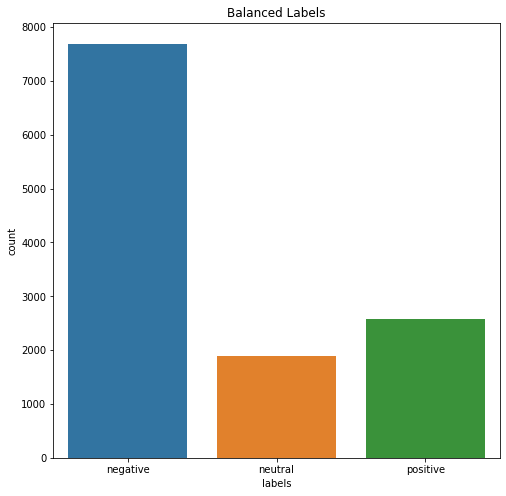

In [5]:
plt.figure(figsize=(8, 8))
sns.countplot('labels', data=df)
plt.title('Balanced Labels')
plt.show()

## Undersample the data

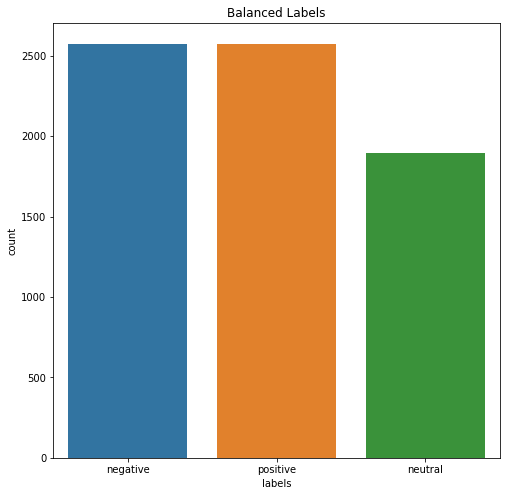

In [7]:
# Shuffle the Dataset
shuffled_df = df.sample(frac=1,random_state=4)

# Put all the positive labels in a separate datasets
positive_df = shuffled_df.loc[shuffled_df['labels'] == 'positive']
neutral_df = shuffled_df.loc[shuffled_df['labels'] == 'neutral']

# Randomly select 2575 observations from the negative label (majority class)
negative_df = shuffled_df.loc[shuffled_df['labels'] == 'negative'].sample(n=2575,random_state=42)

# Concatenate all three dataframes again
normalized_df = pd.concat([negative_df, positive_df, neutral_df])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('labels', data=normalized_df)
plt.title('Balanced Labels')
plt.show()

In [9]:
print(normalized_df.shape)
#normalized_df.to_csv("NormData_path.csv",index=False)

(7045, 3)


## Getting the features of audio files using librosa

In [10]:
df = pd.read_csv("NormData_path.csv")
data = pd.DataFrame(columns=['feature'])

input_duration = 4

for i in tqdm(range(len(df))):
    X, sample_rate = librosa.load(df.path[i],
                                  res_type='kaiser_fast',
                                  duration=input_duration,
                                  sr=22050*2,
                                  offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 7045/7045 [05:19<00:00, 22.04it/s]


In [11]:
data.head()

,feature
0,"[-17.498186, -16.923052, -18.209496, -19.01889..."
1,"[-17.277065, -16.79272, -16.40998, -15.706557,..."
2,"[-52.04405, -52.04405, -52.04405, -52.04405, -..."
3,"[-21.012785, -17.835165, -17.089836, -18.42785..."
4,"[-21.351511, -19.535324, -19.565594, -20.22439..."


In [12]:
df_new = pd.DataFrame(data['feature'].values.tolist())
labels = df.labels

In [13]:
df_new.head()

,0,1,2,3,4,5,6,7,8,9,...,335,336,337,338,339,340,341,342,343,344
0,-17.498186,-16.923052,-18.209496,-19.018898,-15.107430,-15.195522,-14.367937,-13.934706,-12.468779,-11.660690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-17.277065,-16.792721,-16.409981,-15.706557,-16.806917,-16.667513,-17.196861,-19.235281,-18.453226,-19.312126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-21.012785,-17.835165,-17.089836,-18.427853,-17.305687,-15.768848,-15.960073,-15.640894,-15.231248,-17.141172,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-21.351511,-19.535324,-19.565594,-20.224398,-19.516762,-18.878918,-19.025806,-18.829952,-19.683552,-18.385675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
newdf = pd.concat([df_new,labels], axis=1)

In [15]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

7045

In [16]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,336,337,338,339,340,341,342,343,344,labels
0,-17.498186,-16.923052,-18.209496,-19.018898,-15.107430,-15.195522,-14.367937,-13.934706,-12.468779,-11.660690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,negative
1,-17.277065,-16.792721,-16.409981,-15.706557,-16.806917,-16.667513,-17.196861,-19.235281,-18.453226,-19.312126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,negative
2,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,negative
3,-21.012785,-17.835165,-17.089836,-18.427853,-17.305687,-15.768848,-15.960073,-15.640894,-15.231248,-17.141172,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,negative
4,-21.351511,-19.535324,-19.565594,-20.224398,-19.516762,-18.878918,-19.025806,-18.829952,-19.683552,-18.385675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,negative
5,-7.807920,-8.538022,-8.726308,-10.104364,-9.147784,-9.806588,-9.739620,-9.050481,-9.680884,-10.021114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,negative
6,-18.958271,-21.169525,-28.681906,-29.814848,-31.028938,-31.090773,-29.703545,-29.393749,-28.719627,-28.598173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,negative
7,-27.650753,-26.875374,-24.142618,-23.740669,-25.067106,-23.321156,-24.448769,-25.232138,-24.746489,-24.286806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,negative
8,-6.285365,-10.161021,-27.820263,-26.720375,-24.379763,-23.397623,-24.339931,-25.863529,-23.922239,-24.495483,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,negative
9,-40.779808,-41.069378,-43.116722,-45.314552,-45.559837,-45.141392,-45.566971,-45.866497,-45.585758,-44.924397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,negative


In [17]:
rnewdf.isnull().sum().sum()

1169377

In [18]:
rnewdf = rnewdf.fillna(0)
print(rnewdf.shape)
rnewdf.head()

(7045, 346)


,0,1,2,3,4,5,6,7,8,9,...,336,337,338,339,340,341,342,343,344,labels
0,-17.498186,-16.923052,-18.209496,-19.018898,-15.107430,-15.195522,-14.367937,-13.934706,-12.468779,-11.660690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
1,-17.277065,-16.792721,-16.409981,-15.706557,-16.806917,-16.667513,-17.196861,-19.235281,-18.453226,-19.312126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
2,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
3,-21.012785,-17.835165,-17.089836,-18.427853,-17.305687,-15.768848,-15.960073,-15.640894,-15.231248,-17.141172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
4,-21.351511,-19.535324,-19.565594,-20.224398,-19.516762,-18.878918,-19.025806,-18.829952,-19.683552,-18.385675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative


## Data Augmentation

In [19]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    Speed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

In [20]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'labels'])
for i in tqdm(range(len(df))):
    X, sample_rate = librosa.load(df.path[i],
                                  res_type='kaiser_fast',
                                  duration=input_duration,
                                  sr=22050*2,
                                  offset=0.5)
    if df.labels[i]:
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, df.labels[i]]

100%|██████████| 7045/7045 [06:18<00:00, 18.63it/s]


In [21]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'labels'])
for i in tqdm(range(len(df))):
    X, sample_rate = librosa.load(df.path[i],
                                  res_type='kaiser_fast',
                                  duration=input_duration,
                                  sr=22050*2,
                                  offset=0.5)
    if df.labels[i]:
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, df.labels[i]]

100%|██████████| 7045/7045 [30:31<00:00,  3.85it/s]  


In [22]:
len(syn_data1), len(syn_data2)

(7045, 7045)

In [23]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [24]:
df2 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels2 = syn_data1.labels
syndf1 = pd.concat([df2,labels2], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

7045

In [25]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,336,337,338,339,340,341,342,343,344,labels
0,-17.498562,-16.924034,-18.209293,-19.018007,-15.107864,-15.196448,-14.368540,-13.935128,-12.467757,-11.660300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
1,-17.167120,-16.602028,-16.314634,-15.708340,-16.738106,-16.557055,-17.071869,-19.088345,-18.293791,-19.242479,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
2,-45.307632,-43.321396,-42.405796,-45.283878,-45.582024,-45.081367,-44.080818,-43.217430,-44.806641,-46.739632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
3,-19.011932,-16.472893,-15.852385,-17.734648,-16.173740,-14.430904,-15.362841,-15.169073,-14.003381,-15.839488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
4,-20.452738,-18.876011,-19.108355,-19.539534,-18.730267,-18.108244,-18.084749,-18.008375,-18.991880,-17.731855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative


In [26]:
df2 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels2 = syn_data2.labels
syndf2 = pd.concat([df2,labels2], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

7045

In [27]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,336,337,338,339,340,341,342,343,344,labels
0,-16.606407,-16.918339,-19.548260,-20.429079,-17.483339,-17.244930,-15.826342,-14.681252,-13.182990,-14.463037,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
1,-18.425529,-18.081388,-18.641365,-19.709063,-19.458143,-20.010715,-21.139753,-22.736238,-25.335964,-23.896605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
2,-52.731750,-52.731750,-52.731750,-52.731750,-52.731750,-52.731750,-52.731750,-52.731750,-52.731750,-52.731750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
3,-21.579000,-19.446978,-19.570080,-20.203712,-21.154814,-20.689070,-19.082752,-17.419336,-17.003222,-18.016191,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
4,-21.187592,-21.303402,-23.373610,-25.295097,-22.336639,-22.826536,-23.531553,-23.610966,-23.240740,-23.712269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative


In [28]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,336,337,338,339,340,341,342,343,344,labels
0,-17.498186,-16.923052,-18.209496,-19.018898,-15.107430,-15.195522,-14.367937,-13.934706,-12.468779,-11.660690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
1,-17.277065,-16.792721,-16.409981,-15.706557,-16.806917,-16.667513,-17.196861,-19.235281,-18.453226,-19.312126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
2,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,-52.044048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
3,-21.012785,-17.835165,-17.089836,-18.427853,-17.305687,-15.768848,-15.960073,-15.640894,-15.231248,-17.141172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
4,-21.351511,-19.535324,-19.565594,-20.224398,-19.516762,-18.878918,-19.025806,-18.829952,-19.683552,-18.385675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative


In [29]:
#  Stratified Shuffle Split

X = combined_df.drop(['labels'], axis=1)
y = combined_df.labels
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [30]:
y_train.value_counts()

positive    6180
negative    6180
neutral     4548
Name: labels, dtype: int64

In [31]:
# Checking for NaN values
X_train.isna().sum().sum()

0

In [32]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

(16908, 345)
['negative' 'neutral' 'positive']


In [34]:
# Pickel the lb object for future use 
#filename = 'labels'
#outfile = open(filename,'wb')
#pickle.dump(lb,outfile)
#outfile.close()

## Changing dimension for CNN model

In [35]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [36]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


#def fscore(y_true, y_pred):
#    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
#        return 0
#
#    p = precision(y_true, y_pred)
#    r = recall(y_true, y_pred)
#    f_score = 2 * (p * r) / (p + r + K.epsilon())
#    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [37]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(3))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

In [38]:
# Plotting Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 345, 256)          2304      
_________________________________________________________________
activation_1 (Activation)    (None, 345, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 345, 256)          524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 345, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 345, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 345, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 43, 256)          

In [39]:
# Compiling the Model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [40]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)

# Please change the model name accordingly.
model_save = ModelCheckpoint('Augmented_Model.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=500,
                     validation_data=(x_testcnn, y_test), callbacks=[model_save, lr_reduce])

Train on 16908 samples, validate on 4227 samples
Epoch 1/500
16908/16908 [==============================] - 1343s 79ms/step - loss: 1.0450 - accuracy: 0.4653 - val_loss: 1.0340 - val_accuracy: 0.4859
Epoch 2/500
16908/16908 [==============================] - 389s 23ms/step - loss: 1.0023 - accuracy: 0.4969 - val_loss: 1.0114 - val_accuracy: 0.4897
Epoch 3/500
16908/16908 [==============================] - 329s 19ms/step - loss: 0.9842 - accuracy: 0.5154 - val_loss: 1.0093 - val_accuracy: 0.5044
Epoch 4/500
16908/16908 [==============================] - 332s 20ms/step - loss: 0.9705 - accuracy: 0.5238 - val_loss: 1.0002 - val_accuracy: 0.5093
Epoch 5/500
16908/16908 [==============================] - 328s 19ms/step - loss: 0.9598 - accuracy: 0.5310 - val_loss: 0.9943 - val_accuracy: 0.5157
Epoch 6/500
16908/16908 [==============================] - 334s 20ms/step - loss: 0.9459 - accuracy: 0.5444 - val_loss: 0.9813 - val_accuracy: 0.5304
Epoch 7/500
16908/16908 [=========================

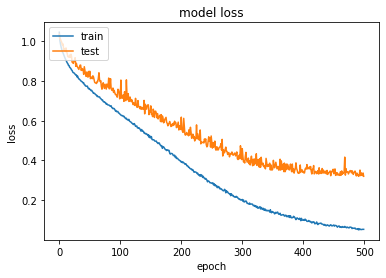

In [41]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
# Saving the model.json

import json
model_json = model.to_json()
with open("MLModel.json", "w") as json_file:
    json_file.write(model_json)

In [43]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('MLModel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("Augmented_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 87.93%


In [44]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

4227/4227 [==============================] - 24s 6ms/step


array([2, 1, 0, ..., 1, 0, 2])

In [45]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predicted_values': preds})

In [46]:
# Actual labels
test_valid_lb = np.array(df.labels)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
actual=test_valid_lb.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actual_values': actual})

In [47]:
# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actual_values,predicted_values
170,negative,positive
171,negative,negative
172,negative,negative
173,negative,positive
174,negative,neutral
175,negative,neutral
176,negative,negative
177,negative,positive
178,negative,positive
179,negative,negative


In [48]:
finaldf.groupby('predicted_values').count()

,actual_values
predicted_values,
negative,1619
neutral,1054
positive,1554
